In [1]:
import numpy as np
import math
import pandas as pd
from pandas import Series
import random

from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


from Data import Data
from datetime import datetime


from scipy import stats

import scipy.stats as st

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

In [27]:
def event_count(t):
    t_index = np.where((t == 0) & (np.roll(t,-1) == 1))[0] + 1
    N = len(t_index)
    if t[0] == 1: N +=1
    return(N)

In [4]:
def unif_generator(l):
    n = 0
    lst = []
    lst.append(np.random.randint(2))
    if (lst[-1] == 1): 
        n = 1
    while (l > n):
        r = np.random.randint(2)
        if(r == 1):
            if(lst[-1]==0):
                lst.append(r)
                n = n + 1
        else:
            lst.append(r)
    return(np.array(lst))

In [34]:
s = unif_generator(20)

In [35]:
s

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [36]:
event_count(s)

20

In [21]:
np.where((t == 0) & (np.roll(t,-1) == 1))[0]

array([ 3,  5,  9, 11, 13, 15, 18, 20, 24, 27, 31, 34, 39, 41, 43, 45, 47,
       49, 51])

In [23]:
np.roll(t,-1)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1])

In [26]:
s[53]

IndexError: index 53 is out of bounds for axis 0 with size 53

In [20]:
1949+34

1983

In [30]:
np.arange(1931,1975,5)

array([1931, 1936, 1941, 1946, 1951, 1956, 1961, 1966, 1971])

In [31]:
np.arange(1949,1974,3)

array([1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973])

In [24]:
np.arange(1983,2008,3)

array([1983, 1986, 1989, 1992, 1995, 1998, 2001, 2004, 2007])

In [26]:
np.arange(1984,2009,3)

array([1984, 1987, 1990, 1993, 1996, 1999, 2002, 2005, 2008])

In [28]:
np.arange(1989,2016,3)

array([1989, 1992, 1995, 1998, 2001, 2004, 2007, 2010, 2013])

In [ ]:
train_start = np.arange(1976,1977,5)
train_end = np.arange(1955,2006,5)
validation_end = np.arange(2010,2011,5)
test_start = np.arange(2001,2002,5)
test_end = np.arange(2015,2016,5)


In [116]:
def spiParametersMle(x, dist=st.gamma):
    i = x == 0
    params = dist.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x, dist=st.gamma):
    i = x == 0

    params = dist.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q, dist=st.gamma):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)
    
    if G == 1: G = 0.99
    if G == 0: G = 0.01
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)


def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

def deseasonalize_NoStd(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = result
    return(data_deseasonal,averages)


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))


In [117]:
level = 12
temporal_limits = {"time_min":datetime(1891, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

result = np.load("ET_data_18912015.npy")

result = pd.DataFrame(result)

In [118]:
result_sum = result.sum(axis=1)

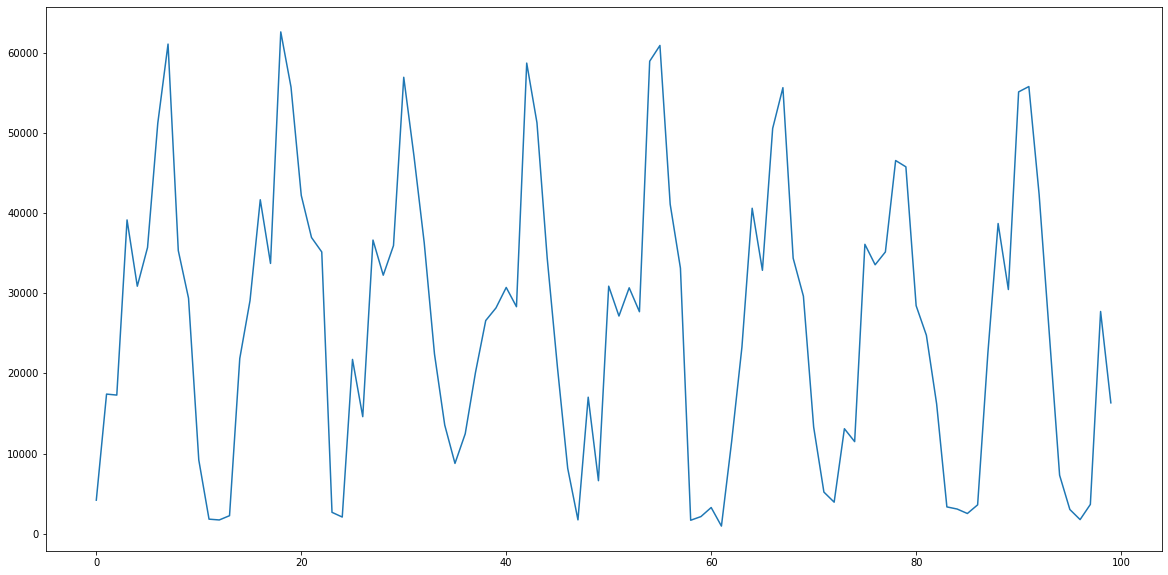

In [119]:
plt.plot(result_sum.values[900:1000])

In [120]:
rolling_n = 12
f = 12
n = 30

In [121]:
RFThree = result_sum.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


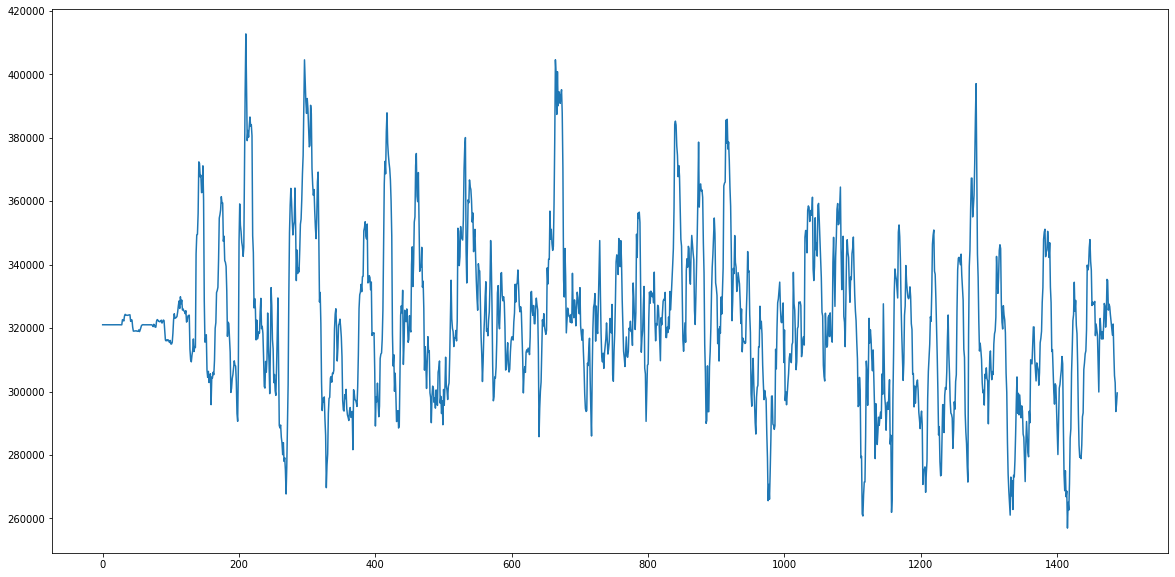

In [144]:
plt.plot(RFThree.values)

In [123]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))
    
    a = RFThree.iloc[onset:end].values
    b = RFThree.iloc[end + (rolling_n - 1)]
    
    params,q = spiParametersMle(a)
    r = spiGeneratorParamMle([b], params, q)
    if np.isinf(r):
        print(k)
    result_index.append(r)
    

In [124]:
r = np.array(result_index)

In [129]:
np.save("ET_gamma_18912015_agg.npy",np.ravel(r))

In [130]:
r = np.ravel(r)

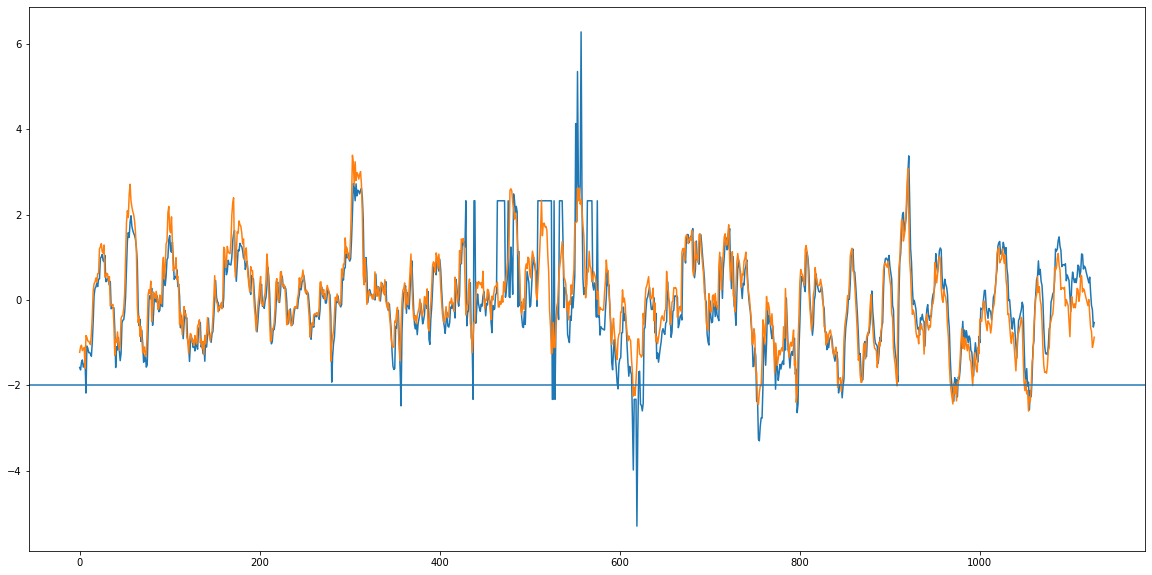

In [152]:
plt.plot(np.arange(len(r)),r,np.arange(len(r)),a)
plt.axhline(-2)

In [146]:
len(RFThree.values)

1489

In [148]:
len(RFThree.values[361:])

1128

In [149]:
a = RFThree.values[361:]

In [150]:
a = (a - a.mean())/a.std()

In [151]:
len(a)

1128

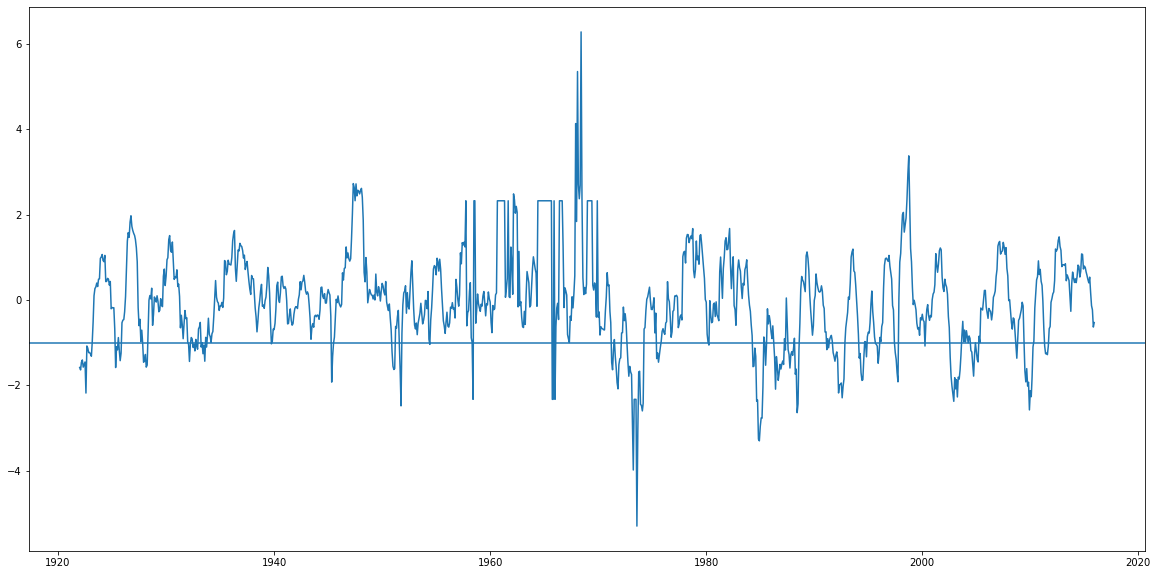

In [141]:
plt.plot(x,r)
plt.axhline(-1)

In [89]:
x = np.arange('1922-01', '2016-01', dtype='datetime64[M]')

In [143]:
len(r)

1128